In [1]:
import networkx as nx


In [2]:
from gurobipy import GRB
import fio.layout


G = nx.read_gml("data/micro.gml")

res, work = fio.layout.compute_layers_multi(G, set(), set(), params={GRB.Param.OutputFlag:0})

for u, l in res.items():
    G.nodes[u]["layer"] = l.numerator



Set parameter Username
Set parameter LicenseID to value 2732003
Academic license - for non-commercial use only - expires 2026-11-03
0.0


In [3]:
G1 = G.copy()

for u, v, data in G.edges(data=True):
    if G.nodes[v]["layer"] < G.nodes[u]["layer"]:
        G1.remove_edge(u, v)
        G1.add_edge(v, u, inv=True, **data)

H = G1.copy()

for u, v in G1.edges():
    if (G1.nodes[v]["layer"] - G1.nodes[u]["layer"]) > 1:
        H.remove_edge(u, v)
        dummies = []
        for l in range(G1.nodes[u]["layer"] + 1, G1.nodes[v]["layer"]):
            dummies.append(f"dummy-{l}-{u}--{v}")
            H.add_node(f"dummy-{l}-{u}--{v}", layer=l)
        nx.add_path(H, [u] + dummies + [v])

    if (G1.nodes[u]["layer"] - G1.nodes[v]["layer"]) >= 0:
        assert False

len(H.nodes)/len(G.nodes)

4.427480916030534

In [4]:
layers = {}
for v, data in H.nodes(data=True):
    r = data["layer"]
    layers.setdefault(r, []).append(v)

print({k:len(l) for k, l in sorted(layers.items())})

{0: 84, 1: 220, 2: 154, 3: 92, 4: 27, 5: 3}


In [5]:
import numpy as np
import math

In [10]:
import random

# --- data ---
nodes = list(H.nodes)
N = len(nodes)

pos = nx.spring_layout(H
                    #    , pos={u: (2*data["layer"]/max(layers)-1, 0)for u, data in H.nodes(data=True)}
)


xmin, ymin = np.min(np.vstack(list(pos.values())), axis=0)
xmax, ymax = np.max(np.vstack(list(pos.values())), axis=0)

spanx = xmax - xmin or 1.0
spany = ymax - ymin or 1.0

# grid size from number of nodes
side   = math.sqrt(len(nodes)) * 4
grid_w = math.ceil(side)
grid_h = math.ceil(side)


cell = set()

# rescale in-place
for u in H.nodes:
    x, y = pos[u]

    nodex = int(round((x - xmin) / spanx * (grid_w - 1)))
    nodey = int(round((y - ymin) / spany * (grid_h - 1)))

    step = 1
    dx = 0
    dy = 0
    while (nodex+dx, nodey+dy) in cell or not (0 <= nodex+dx < grid_w) or not (0 <= nodey+dy < grid_h):
        if dx < step and dy == 0:
            dx += 1
        elif dx == step and dy < step:
            dy += 1
        elif dy == step and dx > -step:
            dx -= 1
        elif dx == -step and dy > -step:
            dy -= 1
        if dx == step and dy == step:
            step += 1

    nodex += dx
    nodey += dy
    cell.add((nodex, nodey))

    pos[u] = np.array((nodex, nodey))

from collections import Counter

assert set(Counter(map(tuple, pos.values())).values()) == {1}

def objective(H, pos):
    obj = 0
    for u, v, k in H.edges(keys=True):
        obj += math.sqrt(np.sum((pos[u] - pos[v])**2))
    
    return obj

objective(H, pos)

9599.24340252676

In [ ]:
import random

assert isinstance(H, nx.MultiDiGraph)

def compactify(H, pos):

    cell = set(map(tuple, pos.values()))

    newpos = dict(pos.items())

    nodes = list(H.nodes())
    for step in range(1000):
        random.shuffle(nodes)
        for u in nodes:
            x, y = newpos[u]
            if set(H.neighbors(u)) == set():
                continue
            dpos = (newpos[u] - np.median(np.vstack(list(newpos[x] for x in H.neighbors(u))))) + np.random.normal(size=(2,))
            dx, dy = -np.array(np.clip(dpos, -1, 1), dtype=int)
            if (x+dx, y+dy) not in cell:
                newpos[u] = np.array((x+dx, y+dy))
                cell.remove((x, y))
                cell.add((x+dx, y+dy))
        
        if step % 100 == 0:
            print(objective(H, newpos))
    
    return newpos

newpos = move_positions(H, pos)  
objective(H, newpos)

9292.865192429046
5790.548594420844
5799.791825603573
5797.186024671856
5794.736699536924
5777.729308907924
5769.683429261441
5765.442704228656
5766.899127819835
5764.640199190343


5757.479460013191

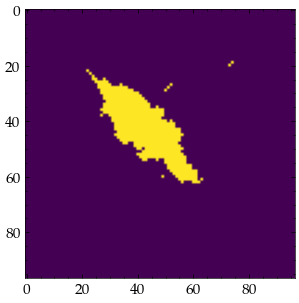

In [12]:
from matplotlib import pyplot as plt

img = np.zeros((grid_w, grid_h))

for x, y in newpos.values():
    img[x, y] = 1
plt.imshow(img)

In [ ]:
import numpy as np

nx.draw(H, newpos, node_size=3)

In [ ]:
print(max(cell))
print(min(cell))